本案例仅仅用于演示和测试`alphalens`包，策略本身并没有实际意义

In [ ]:
%load_ext zipline

### 运行策略

In [ ]:
%%zipline --start 2018-1-1 --end 2018-5-2 -o result.pkl

import talib
import numpy as np
import math
import logbook

from zipline.api import *
from zipline.pipeline.fundamentals import Fundamentals
from zipline.pipeline import Pipeline
from zipline.pipeline.builtin import TopAverageAmount
from zipline.pipeline.factors import RSI

from zipline.finance import commission, slippage

log = logbook.Logger('RSI')


def make_pipeline():

    return Pipeline(
        columns={
            'rsi': RSI(window_length=15),
            'sector': Fundamentals.info.sector_code.latest,
        },
        # 只选择成交额前500位的股票
        screen=TopAverageAmount(500))


# Setup our variables
def initialize(context):
    # 设置手续费及滑点
    set_commission(commission.PerShare(cost=0))
    set_slippage(slippage.FixedSlippage(spread=0))
    
    context.max_notional = 100000
    context.intc = sid(333)  #symbols(['000333','000002','300017'])
    context.LOW_RSI = 30
    context.HIGH_RSI = 70
    attach_pipeline(make_pipeline(), 'rsi_pipeline')
    schedule_function(rebalance, date_rules.every_day(),
                      time_rules.market_open())


def before_trading_start(context, data):
    #context.output = pipeline_output('rsi_pipeline')
    #print(context.output.head())
    pass

def rebalance(context, data):
    # 接收pipeline输出结果
    output = pipeline_output('rsi_pipeline')

    # Get our current positions
    positions = context.portfolio.positions
    
    # 信号触发可卖出和可买入的股票
    signal_sell = output[output['rsi'] > context.HIGH_RSI].index
    signal_buy = output[output['rsi'] < context.LOW_RSI].index
    
    for s in signal_sell:
        # 存在于持有的头寸中
        if s in positions:
            # 清空头寸
            order_target(s, 0)
            # amount代表持仓数量，而非金额
            current_intel_shares = positions[s].amount
            log.info('RSI is at ' + str(s) + ', 卖出 ' +
                     str(current_intel_shares) + ' shares')
            
    for s in signal_buy:
        # 对于信号提示可买入，但尚未买入的股票，买入固定金额
        if s not in positions:
            o = order_target_value(s, context.max_notional)
            log.info('RSI is at ' + str(s) + ', 买入 ' +
                     str(get_order(o).amount) + ' shares')

    # record the current RSI value and the current price of INTC.
    # record(intcRSI=intc_rsi, intcPRICE=data.current(context.intc, 'close'))

### 整理及补充数据

#### 使用研究模块提取数据
+ 如果存在分红派息，自动调整期间股价
+ 必须与回测期间相同

In [ ]:
from zipline.research import run_pipeline

In [ ]:
from zipline.pipeline.fundamentals import Fundamentals
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.builtin import TopAverageAmount

In [ ]:
def make_pipeline():

    return Pipeline(
        columns={
            'close': USEquityPricing.close.latest,
            'sector': Fundamentals.info.sector_code.latest,
        },
        # 只选择成交额前500位的股票
        screen=TopAverageAmount(500))

In [ ]:
pipe_output = run_pipeline(make_pipeline(), '2018-1-1', '2018-5-2')

#### 整理数据

In [ ]:
# 价格数据必须转换为日期为Index,stock为列名称的宽表
prices = pipe_output.unstack()['close']

In [ ]:
prices.head()

In [ ]:
factors = pipe_output['sector']
# 行业分类因子期间内不会改变，类型为整数
factors.fillna(method='bfill',inplace=True)
factors.fillna(method='ffill',inplace=True)
factors = factors.astype('int64')

In [ ]:
factors.head()

### 投资组合分析

In [1]:
import pyfolio as pf
import pandas as pd
import empyrical as ep

#### 提取指标

In [2]:
results = pd.read_pickle('result.pkl')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [3]:
transactions.tail()

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2018-05-02 07:00:00+00:00,-9643,None,2018-05-02 07:00:00+00:00,None,10.26,麦达数字(002137),麦达数字(002137),98937.18
2018-05-02 07:00:00+00:00,-3028,None,2018-05-02 07:00:00+00:00,None,33.21,德赛西威(002920),德赛西威(002920),100559.88
2018-05-02 07:00:00+00:00,-4777,None,2018-05-02 07:00:00+00:00,None,20.58,朗新科技(300682),朗新科技(300682),98310.66
2018-05-02 07:00:00+00:00,-4810,None,2018-05-02 07:00:00+00:00,None,20.46,中国医药(600056),中国医药(600056),98412.60
2018-05-02 07:00:00+00:00,-12500,None,2018-05-02 07:00:00+00:00,None,7.90,安彩高科(600207),安彩高科(600207),98750.00


#### 单图例子
制作排名前5位的回撤时段

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Text(0.5,0,'日期')

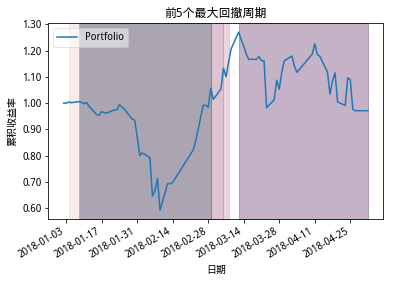

In [4]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('日期')

#### 完整`tear sheet`(工作底稿)示例
为算法创建一个完整的工作表。例如，将实时开始日期设置为任意值。

**一般而言，`live_start_date`应设置接近回测结束日期**

In [5]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2018-04-04', round_trips=True)

AttributeError: 'Index' object has no attribute 'freq'

### 因子分析

In [ ]:
from alphalens.utils import get_clean_factor_and_forward_returns

In [ ]:
get_clean_factor_and_forward_returns(factor=factors, prices=prices,max_loss=0)